In [12]:
import math
import numpy as np
import re
import string
import cv2
import os
import errno
import random
import string

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
inputWidth = 18
inputHeight = 22

In [13]:
#reload model for further training
from numpy import loadtxt
from keras.models import load_model

from numpy import loadtxt
from keras.models import load_model

from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
 
# load model
letter_loaded_model = load_model('letterRealModel.h5')
# # summarize model.
letter_loaded_model.summary()
# load dataset

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 16, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 8, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 3, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [22]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [14]:
def blurData(grayImage):
    kernelSize = random.randrange(1, 3+1, 2)
    return cv2.GaussianBlur(grayImage,(kernelSize,kernelSize),cv2.BORDER_DEFAULT)

realDataGen = ImageDataGenerator(
                              brightness_range=[0.8,1.0],
                              rotation_range = 10,
                              zoom_range = [0.8,1],
#                               validation_split = 0.2,
#                               width_shift_range = 0.2,
#                              height_shift_range = 0.2,
                             shear_range=0.2,
#                              validation_split = 0.2,
                             preprocessing_function = blurData
    
                            )


In [15]:
# second round of training with real data from the world
dataPath = "./realData"
letterDataPath = dataPath + "/letter"
letterLabels = list(string.ascii_uppercase)
letterDataDictionary = {"image" : [] , "vector": [], "label": []}

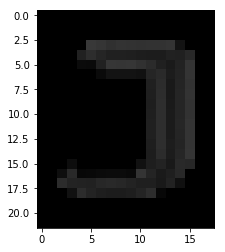

In [17]:
for file in os.listdir(letterDataPath):
    if(file.endswith('.png')):
        image = cv2.imread(letterDataPath + '/' + file)
        image = cv2.resize(image,(inputWidth,inputHeight))

        grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        grayImage3 = np.repeat(grayImage[..., np.newaxis], 3, -1)
        plt.imshow(grayImage3)
#         imageBlur = cv2.GaussianBlur(image,(11,11),cv2.BORDER_DEFAULT)
        dataLabel = file[0]
        #creating the vector
        vec = [0] * 36
        index = letterLabels.index(dataLabel)
        vec[index] = 1
#         print(grayImage)
        letterDataDictionary["image"].append(grayImage3/255.0)#?
        letterDataDictionary["vector"].append(vec)
        letterDataDictionary["label"].append(dataLabel)
        

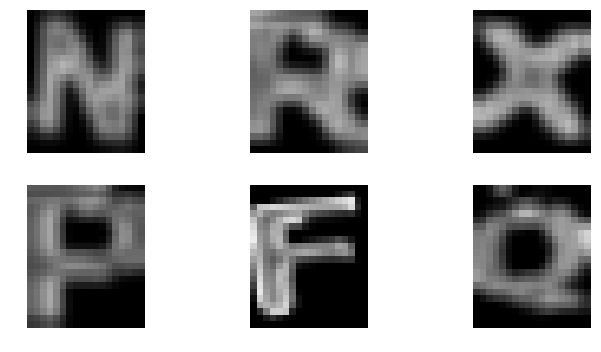

103

In [18]:

datax_train = np.array(letterDataDictionary["image"])
datay_train = np.array(letterDataDictionary["vector"])

data_training_generator = realDataGen.flow(datax_train,datay_train,batch_size=20)
# validation_generator = realDataGen.flow(datax_train, datay_train, batch_size=64,subset='validation')

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in data_training_generator:
        plt.imshow((x[0]/255),cmap='gray')
#         plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()
len(datax_train)

In [20]:
LEARNING_RATE = 1e-4
letter_loaded_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])


In [27]:

history_conv = number_loaded_model.fit_generator(data_training_generator,steps_per_epoch=(len(datax_train))//20, epochs=60, validation_data=data_training_generator, validation_steps=(len(datax_train))//20)

Epoch 1/60
2/2 [==============================] - 0s 106ms/step - loss: 0.7084 - acc: 0.9500 - val_loss: 0.3229 - val_acc: 0.9750
Epoch 2/60
2/2 [==============================] - 0s 60ms/step - loss: 1.9015 - acc: 0.8077 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 3/60
2/2 [==============================] - 0s 10ms/step - loss: 0.6214 - acc: 0.9231 - val_loss: 0.5683 - val_acc: 0.9231
Epoch 4/60
2/2 [==============================] - 0s 61ms/step - loss: 0.2416 - acc: 0.9231 - val_loss: 0.0018 - val_acc: 0.9750
Epoch 5/60
2/2 [==============================] - 0s 132ms/step - loss: 0.8149 - acc: 0.8500 - val_loss: 0.4113 - val_acc: 0.9615
Epoch 6/60
2/2 [==============================] - 0s 22ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 7/60
2/2 [==============================] - 0s 70ms/step - loss: 0.1664 - acc: 0.9500 - val_loss: 0.1840 - val_acc: 0.9750
Epoch 8/60
2/2 [==============================] - 0s 100ms/step - loss: 0.0643 - acc: 0.9167 - 

('predicted value:', 'P')
('ground truth:', 'O')


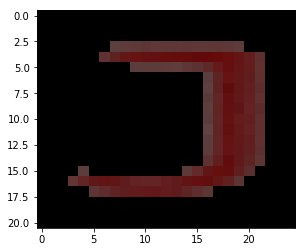

In [31]:
# test the model
def testModel(img,truth):
  grayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_aug = np.repeat(grayImg[..., np.newaxis], 3, -1)
  img_aug = cv2.resize(img_aug,(inputWidth,inputHeight))
  img_aug = np.expand_dims(img_aug, axis=0)
  y_predict = letter_loaded_model.predict(img_aug)[0]
#   print(y_predict)
  plt.imshow(img)
  predictVal = max(y_predict)
#   print(predictVal)
  predictedVal_index = np.where(y_predict == predictVal)[0][0]
  predictedVal = letterLabels[predictedVal_index]
#   groundTruth_index = np.where(datay_train[index] == 1)[0][0]
#   groundTruth = labels[groundTruth_index]
#   print("predicted value:",format(predictedVal))
#   print("ground truth:",format(truth))
  if (predictedVal != truth):
   print("predicted value:",format(predictedVal))
   print("ground truth:",format(truth))


dataPath = "./realData/letter"
y_test = []
y_true = []

for file in os.listdir(dataPath):
    if(file.endswith('.png')):
        truth = file[0]
        image = cv2.imread(dataPath + '/' + file) #converts to grey scale
        width, height, dim = image.shape
#         image = cv2.resize(image,(95,170))
        plt.imshow(image)
        testModel(image,truth)
    
        

In [32]:
#Use to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    print ("Classes:")
    print classes
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 

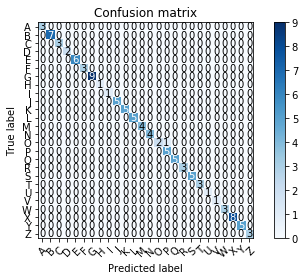

In [34]:
#Process data for confusion matrix plotting 
y_test = []
y_true = []

for file in os.listdir(dataPath):
    if(file.endswith('.png')):
        y_true.append(file[0])
#         print("Y true:")
#         print(y_true)
        image = cv2.imread(dataPath + '/' + file) #converts to grey scale
        grayImg = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        img_aug = np.repeat(grayImg[..., np.newaxis], 3, -1)
        img_aug = cv2.resize(img_aug,(inputWidth,inputHeight))
        img_aug = np.expand_dims(img_aug, axis=0)
        y_predict = letter_loaded_model.predict(img_aug)[0]
        predictVal = max(y_predict)
        predictedVal_index = np.where(y_predict == predictVal)[0][0]
        predictedVal = letterLabels[predictedVal_index]
        y_test.append(predictedVal)
#         print("Y test:")
#         print(y_test)
    
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_test, classes=letterLabels, normalize=False,
                      title='Confusion matrix')

plt.show()


In [50]:
number_loaded_model.save("numberswithparking.h5")
